In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Preparing the data
import pathlib

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setting the path to the dataset directory
data_dir = r"/content/drive/MyDrive/Thesis_Kidney_Stone"
data_dir = pathlib.Path(data_dir)

In [5]:
img_height, img_width = 224, 224
batch_size = 64



train_datagen=tf.keras.preprocessing.image.ImageDataGenerator (
    rescale=1./255,
    zoom_range=0.2,
    rotation_range = 10,
    horizontal_flip=True,
    validation_split=0.1)

validation_datagen=tf.keras.preprocessing.image.ImageDataGenerator (
    rescale=1./255,
    zoom_range=0.2,
    rotation_range = 10,
    horizontal_flip=True,
    validation_split=0.1
)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1799 files belonging to 2 classes.
Using 1440 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1799 files belonging to 2 classes.
Using 359 files for validation.


In [8]:
# Printing classes
class_names = train_ds.class_names
print(class_names)

['Test', 'Train']


In [9]:
# Training the model
resnet101_model = Sequential()
IMAGE_SIZE = [224,224]
resnet=ResNet101(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)
resnet.output

171446536/171446536 [==============================] - 1s 0us/step


<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [10]:
for layer in resnet.layers:
    layer.trainable = False

In [11]:
folders=glob("/content/drive/MyDrive/Thesis_Kidney_Stone/*")
print(len(folders))

2


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
x=Flatten()(resnet.output)
prediction=Dense(64,activation='relu')(x)
prediction=Dense(len(folders), activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [13]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
epochs = 50
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
23/23 [==============================] - 225s 6s/step - loss: 6.0491 - accuracy: 0.7340 - val_loss: 2.1501 - val_accuracy: 0.8412
Epoch 2/50
23/23 [==============================] - 34s 1s/step - loss: 0.8240 - accuracy: 0.9111 - val_loss: 1.1916 - val_accuracy: 0.8078
Epoch 3/50
23/23 [==============================] - 34s 1s/step - loss: 0.2842 - accuracy: 0.9563 - val_loss: 0.6315 - val_accuracy: 0.8886
Epoch 4/50
23/23 [==============================] - 35s 1s/step - loss: 0.0470 - accuracy: 0.9944 - val_loss: 0.5785 - val_accuracy: 0.9109
Epoch 5/50
23/23 [==============================] - 34s 1s/step - loss: 0.0224 - accuracy: 0.9965 - val_loss: 0.5409 - val_accuracy: 0.9192
Epoch 6/50
23/23 [==============================] - 34s 1s/step - loss: 0.0269 - accuracy: 0.9965 - val_loss: 0.5127 - val_accuracy: 0.9053
Epoch 7/50
23/23 [==============================] - 35s 1s/step - loss: 0.0257 - accuracy: 0.9958 - val_loss: 0.7653 - val_accuracy: 0.8914
Epoch 8/50
23/23 [=

In [15]:
best_accuracy = max(history.history['accuracy'])
print("Best Training Accuracy:", best_accuracy)

best_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy:", best_accuracy)

Best Training Accuracy: 0.9979166388511658
Best Validation Accuracy: 0.941504180431366


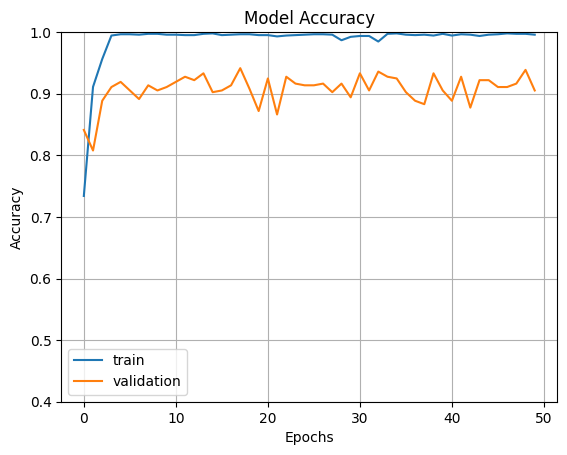

In [16]:
# Evaluating the model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

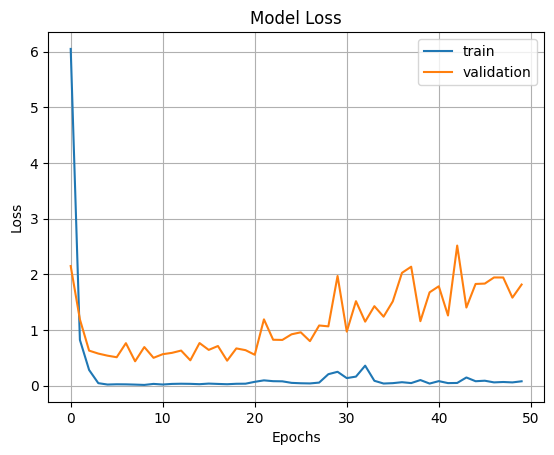

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
# Generate predictions for the validation dataset
val_predictions = model.predict(val_ds)

# Convert predictions to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)

# Get true labels for the validation dataset
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_true_labels = np.argmax(val_true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

6/6 [==============================] - 10s 297ms/step


In [19]:
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[  9  53]
 [ 25 272]]


In [20]:
class_names1 = ['Kidney_stone','Normal']

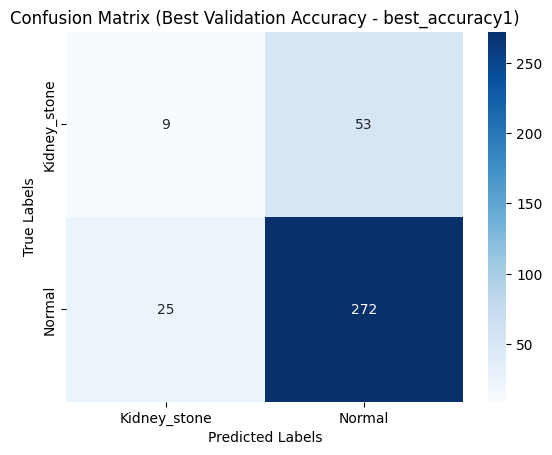

In [21]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names1, yticklabels=class_names1)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Validation Accuracy - best_accuracy1)')
plt.show()